##1. Imports and Drive mounting


In [ ]:
#imports and Drive mounting
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.__version__)

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import sklearn as sk
import pandas as pd
from pandas import read_csv
from datetime import datetime
import math
import os
from sklearn.metrics import mean_absolute_error

# fix random seed for reproducibility
seed = 2020
np.random.seed(seed)  

from sklearn.model_selection import train_test_split

from tensorflow.keras.datasets import cifar100
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.regularizers import L1L2
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model
from tensorflow.keras import optimizers
from tensorflow.keras.losses import MAE
from google.colab import files

# uncomment if you want to use Drive

from google.colab import drive
drive.mount('/content/gdrive')


# !ls '/content/gdrive/My Drive/'

2.4.1
Mounted at /content/gdrive


##2. Reading the data set


In [ ]:
# load dataset

# this code only loads train and test datasets

# remember you also need to split off a validation dataset
# either by reusing and adapting the splitting code from the preprocessing notebook 
# or by writing your own code
# like in the previous assignments, this means you should have 4 sets:

# train_all (train+validate), train, validate and test

# The PATH setting below assumes you just uploaded the data file to your Colab session
# When using Drive: replace this by the path where you put the data file
DATAPATH = '/content/gdrive/My Drive/Assignments/GA3/preprocessed_data/'
TRAINDATAFILE = DATAPATH+'preprocessed_train_data.csv'
VALDATAFILE = DATAPATH+'preprocessed_val_data.csv'
TESTDATAFILE = DATAPATH+'preprocessed_test_data.csv'

train_dataset = read_csv(TRAINDATAFILE, header=0, index_col=0)
val_dataset = read_csv(VALDATAFILE, header=0, index_col=0)
test_dataset = read_csv(TESTDATAFILE, header=0, index_col=0)

#check - note that you can make many other plots directly from pandas dataframes:
# https://pandas.pydata.org/pandas-docs/version/0.16/visualization.html

#train_dataset.plot(subplots=True,figsize=(16,26))

##3. Extract train, validate and test features and labels

In the code below, we will split of a validation set that is the same size as the test set (1 year) at the end of the training set.

In [ ]:
print(train_dataset.columns)
print(len(train_dataset.columns))

Index(['pollution', 'dew', 'temp', 'press', 'wnd_spd', 'snow', 'rain',
       'seasons_cos', 'seasons_sin', 'hour_cos', 'hour_sin', 'weekdays',
       'is_Friday', 'is_Monday', 'is_Saturday', 'is_Sunday', 'is_Thursday',
       'is_Tuesday', 'is_Wednesday', 'NE_strength', 'NW_strength',
       'NS_strength', 'cv_strength'],
      dtype='object')
23


In [ ]:
# extract data from dataframes, selecting the features you want
# note that the labels simply contain the pollution data for now
# depending on the window sizes used in training, the correct values will be cut out

#using indexing, you can select which features you want to use (adapt to your needs)
features = range(0,len(train_dataset.columns))

# index of the pollution data in the complete preprocessed feature set 
pollution = 0


# Important: Tensorflow 2.x gives an error if you omit
# the np.asarray(...,,dtype=np.float32)

# train and validate
train_values = np.asarray(train_dataset.values[:,features],dtype=np.float32)
train_labels = np.asarray(train_dataset.values[:,pollution],dtype=np.float32)
val_values = np.asarray(val_dataset.values[:,features],dtype=np.float32)
val_labels = np.asarray(val_dataset.values[:,pollution],dtype=np.float32)

# data for retraining before testing
train_all_values = np.concatenate((train_values,val_values))
train_all_labels = np.concatenate((train_labels,val_labels))

# test data
test_values = np.asarray(test_dataset.values[:,features],dtype=np.float32)
test_labels = np.asarray(test_dataset.values[:,pollution],dtype=np.float32)


# check
print(train_values.shape)
print(train_labels.shape)
print(val_values.shape)
print(val_labels.shape)

print(train_all_values.shape)
print(train_all_labels.shape)

print(test_values.shape)
print(test_labels.shape)


(26280, 23)
(26280,)
(8760, 23)
(8760,)
(35040, 23)
(35040,)
(8760, 23)
(8760,)


##4. Normalising the data

As you know by now, it is important to normalise the data. The flow is the following:

- initialise normaliser 1
- fit on training date
- use it to transform train and validation data

For your final model(s) you need a second normaliser:
- initialise normaliser 2
- fit on training+validation data
- use it to transform training+validation and test data

This has to be done **before** reformatting the data into windows (next section).  

Although we already did this before, the code below gives an example, The imports show that there are many different scalers. Especially with recurrent NNs, the choice of scaler can make a difference. Look up what each scaler does before choosing which one to try. Also, recurrent models may need different scalers than other models. Finally, you could also consider to start with a batchnorm layer to let your model fine-tune the feature scaling.


In [ ]:
# imports to show that there are many different scalers
# especially with recurrent NNs, the choice of scaler can make a difference
# look up what they do before choosing which one to try

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer

# Example: train standard scalers, apply to train and test data
# adapt to do all you need to do ...

# SS1 = StandardScaler()
# SS1.fit(train_values)

# train_scaled = SS1.transform(train_values)
# val_scaled = SS1.transform(val_values)

# SS2 = StandardScaler()
# SS2.fit(train_all_values)

# train_all_scaled = SS2.transform(train_all_values)
# test_scaled = SS2.transform(test_values)

MMS1 = MinMaxScaler()
MMS1.fit(train_values)

train_scaled = MMS1.transform(train_values)
val_scaled = MMS1.transform(val_values)

MMS2 = MinMaxScaler()
MMS2.fit(train_all_values)

train_all_scaled = MMS2.transform(train_all_values)
test_scaled = MMS2.transform(test_values)

##5. Transforming the data into the right format for model training

In the code below, helper functions are defined for the window-based model.

In [ ]:
# window-based and recurrent networks:
# now, you use a window of k history values to predict
# this means that the features of the first k timesteps (indices 0 to k-1)
# are used to predict the k+3rd pollution value (index k+3-1)
# output dimension of train data is samples x window x features

def create_dataset_windowed(train, test, ahead=3, window_size=1):
  samples = train.shape[0]-ahead-(window_size-1) 
  dataX= []
  for i in range(samples):
      a = train[i:(i+window_size), :]
      dataX.append(a)
  return np.array(dataX), test[ahead+window_size-1:]

In [ ]:
def PlotResults(labels,predictions,binsize = 10):
  num_samples = len(labels)
  
  fig = plt.figure(figsize=(16,16))
  spec = gridspec.GridSpec(ncols=4, nrows=4, figure=fig)
  ax1 = fig.add_subplot(spec[0, :])
  ax2 = fig.add_subplot(spec[1, :])
  ax3 = fig.add_subplot(spec[2:,0:2])
  ax4 = fig.add_subplot(spec[2:,2:])
  
  ax1.plot(labels,'k-',label='Labels')
  ax1.plot(predictions,'r-',label='Predictions')
  ax1.set_ylabel('Pollution')
  ax1.legend()
  
  errors=np.absolute(labels-predictions)
  ax2.plot(errors,'k-')
  ax2.set_ylabel("Absolute error")
  
  ax3.scatter(labels,predictions)
  ax3.set_xlabel('Labels')
  ax3.set_ylabel('Predictions')

  bins = np.arange(0,(np.ceil(np.max(errors)/binsize)+1)*binsize,binsize)
  
  ax4.hist(errors,bins=bins)
  ax4.set_xlabel('Absolute error')
  ax4.set_ylabel('Frequency')

  plt.show()


In [ ]:
def plot_history(history):
  plt.figure(figsize = (6,4))
  
  plt.xlabel('Epoch')
  plt.ylabel('Mae')
  plt.plot(history.epoch, np.array(history.history['mae']),'g-',
           label='Train MAE')
  plt.plot(history.epoch, np.array(history.history['val_mae']),'r-',
           label = 'Validation MAE')
  plt.legend()
  plt.show()

##6. Building the GRU model


In [ ]:
def construct_model(HIDDEN_RNN, RNN_WINDOW_SIZE):
  GRUmodel = Sequential()

  # Note that you can also make multi-layer GRUs 
  # Since these send their output to another GRU, they should output whole sequences 
  # instead of predictions
  # For this reason, all but the last GRU layer should have return_sequences=True

  GRUmodel.add(GRU(input_shape = (RNN_WINDOW_SIZE,23), 
                    units=HIDDEN_RNN,
                    return_sequences=False, 
                    kernel_regularizer=wreg))
  # GRUmodel.add(Dense(64,activation='relu'))
  act_func='relu'
  dropout = 0
  GRUmodel.add(Dense(32,activation=act_func,kernel_regularizer=dreg))
  # GRUmodel.add(Dropout(dropout))
  GRUmodel.add(Dense(16,activation=act_func,kernel_regularizer=dreg))
  # GRUmodel.add(Dropout(dropout))
  GRUmodel.add(Dense(8,activation=act_func,kernel_regularizer=dreg)) # note that a different nonlinearity may be useful here
  # GRUmodel.add(Dropout(dropout))
  # GRUmodel.add(Dense(4,activation=act_func))
  GRUmodel.add(Dense(1))
  return GRUmodel

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 16)                1968      
_________________________________________________________________
dense (Dense)                (None, 32)                544       
_________________________________________________________________
dense_1 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 3,185
Trainable params: 3,185
Non-trainable params: 0
_________________________________________________________________
Models will be saved in  /content/gdrive/My Drive/Colab Notebooks/DL2021/GA3
Epoch 1/50
411/411 [=======================

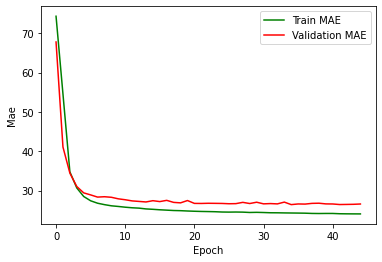

In [ ]:
HIDDEN_RNN = 16
RNN_WINDOW_SIZE = 6

# current code for pollution-only, add other features for multi-feature model, 
# remove indices as in commented code if you want to use all features
# train_features = [0,] 
train_features = range(0,len(train_dataset.columns)) #Using all features

X_train_w,r_train_w = create_dataset_windowed(train_scaled[:,train_features],train_labels, window_size=RNN_WINDOW_SIZE)
X_val_w,r_val_w = create_dataset_windowed(val_scaled[:,train_features],val_labels, window_size=RNN_WINDOW_SIZE)

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=RNN_WINDOW_SIZE)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=RNN_WINDOW_SIZE)

# regularisers - all set to zero for now
# wreg = L1L2(l1=1e-6, l2=1e-3)
wreg = L1L2(l1=1e-3, l2=0)
dreg = L1L2(l1=1e-5, l2=0)

GRUmodel = construct_model(HIDDEN_RNN, RNN_WINDOW_SIZE)
GRUmodel.summary()
GRUmodel.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='mae', metrics=['mae','mse'])

checkpoint_dir = "/content/gdrive/My Drive/Colab Notebooks/DL2021/GA3"
print("Models will be saved in ",checkpoint_dir)
model_savename = checkpoint_dir+"grumodel_model_version_0.1.h5"
checkpoint_path = checkpoint_dir+"cp-{epoch:04d}.ckpt"

cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, 
                                                monitor='val_mae',
                                                save_weights_only=True,
                                                save_best_only=True,
                                                verbose=1)

stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_mae', patience=10,min_delta=0.0001)

batch_size=64
epochs=50
GRU_history = GRUmodel.fit(X_train_w, r_train_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(X_val_w, r_val_w),
          callbacks=[stopping_callback, cp_callback],
          shuffle=False)

plot_history(GRU_history)

In [ ]:
y_train_GRUmodel = GRUmodel.predict(X_train_w)
y_val_GRUmodel = GRUmodel.predict(X_val_w)

mae_train_GRUmodel = mean_absolute_error(r_train_w,y_train_GRUmodel)
mae_val_GRUmodel = mean_absolute_error(r_val_w,y_val_GRUmodel)

print("\"Current pollution\" baseline:\n train mae = ",mae_train_GRUmodel,
      "\n validation mae = ",mae_val_GRUmodel)

# Visualise first 1000 predictions for validation
# PlotResults(r_val_w[:1000],y_val_GRUmodel[:1000,0])

"Current pollution" baseline:
 train mae =  24.034279 
 validation mae =  26.608847


##7. Train best model on full training set and evaluate performance on the test set

In [ ]:
# Code needs to be adapted to the best model so far!!!!
train_features = range(0,len(train_dataset.columns)) #Using all features

X_train_all_w,r_train_all_w = create_dataset_windowed(train_all_scaled[:,train_features],train_all_labels, window_size=6)
X_test_w,r_test_w = create_dataset_windowed(test_scaled[:,train_features],test_labels, window_size=6)

#Recreate the best optimal model

final_model = construct_model(16, 6)
final_model.summary()

final_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),loss='mae', metrics=['mae','mse'])

batch_size=64
epochs=49

final_model_history = final_model.fit(X_train_all_w, r_train_all_w, 
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          shuffle=True)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 16)                1968      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 8)                 136       
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 9         
Total params: 3,185
Trainable params: 3,185
Non-trainable params: 0
_________________________________________________________________
Epoch 1/49
548/548 [==============================] - 5s 5ms/step - loss: 80.5093 - mae: 80.3780 - mse: 13517.8867
Epo

In [ ]:
y_train_all = final_model.predict(X_train_all_w)
y_test = final_model.predict(X_test_w)

mae_train_all = mean_absolute_error(r_train_all_w,y_train_all)
mae_test = mean_absolute_error(r_test_w,y_test)

print("\"RNN-GRU\" model:\n train all mae = ",mae_train_all, "\n test mae = ",mae_test)

"RNN-GRU" model:
 train all mae =  24.402163 
 test mae =  23.515162


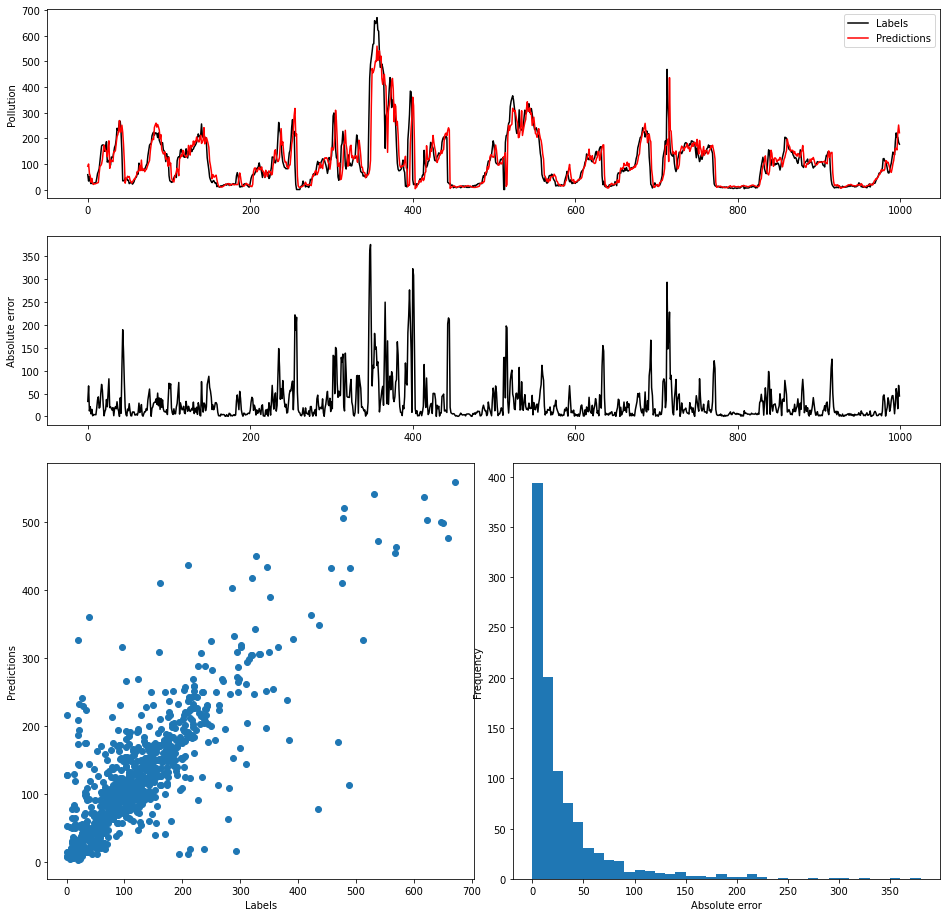

In [ ]:
PlotResults(r_test_w[:1000],y_test[:1000,0])